In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy.io as sio
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
import sklearn.metrics
from sklearn.utils import shuffle 
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Conv3D, MaxPooling3D, BatchNormalization
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.models import clone_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
import time


import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy.io as sio
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
import sklearn.metrics
from sklearn.utils import shuffle 
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Conv3D, MaxPooling3D, BatchNormalization
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Reshape, LSTM, Bidirectional, Flatten, Dense


from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, roc_auc_score

import numpy as np
from tensorflow.keras.utils import to_categorical
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

2024-04-22 21:50:54.307009: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 21:50:54.307104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 21:50:54.463098: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_24/321466138.py:59: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
data  = np.load("/kaggle/input/deap-fe-own-shuffled/Shuffled/De/DEAP_DE_X.npy")
labels_edited  = np.load("/kaggle/input/deap-fe-own-shuffled/Shuffled/De/DEAP_DE_arousal_y.npy")

In [3]:
max = np.max(data)
min = np.min(data)

#Normalizing data
data = data/max
data = (data - np.mean(data))/np.std(data)


#Splitting Dataset into train, validation, test 
train_labels = labels_edited[0:1080]
test_labels = labels_edited[1080:1180]
final_labels = labels_edited[1180:1280]

train_data = data[0:1080]
test_data = data[1080:1180]
final_test = data[1180:1280]



cf_labels = np.where(final_labels== -1, 2, final_labels) #Label in the form for confusion matrix
un, co = np.unique(cf_labels, return_counts=True)
print(f'Unique: {un}, Counts: {co}')

Unique: [0 1], Counts: [50 50]


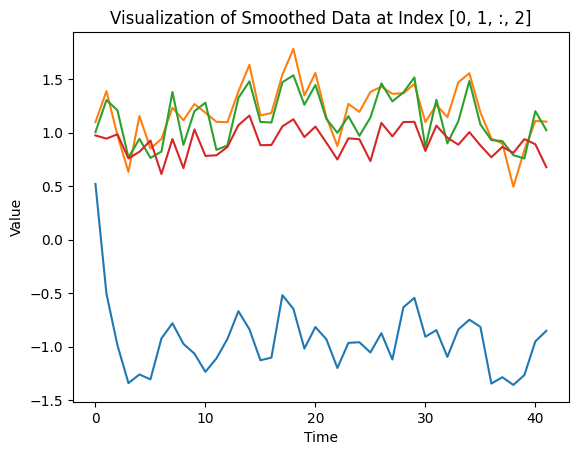

In [4]:
# Visualize the smoothed data
plt.plot(data[0, 2, :, :])
plt.title("Visualization of Smoothed Data at Index [0, 1, :, 2]")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

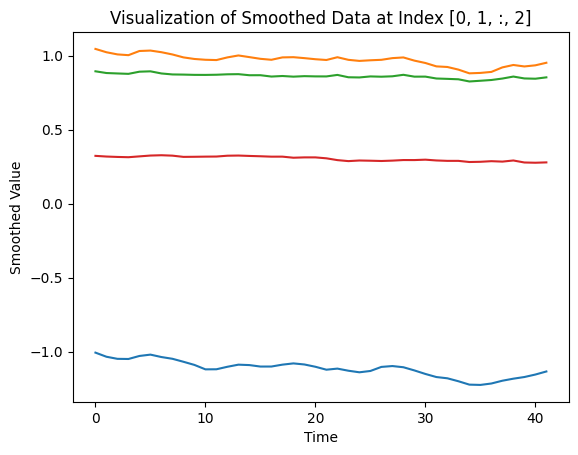

In [5]:
import pandas as pd

# Define the window size for the moving average filter
window_size = 40

# Apply the moving average filter
smoothed_data = np.zeros_like(data)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        for k in range(data.shape[3]):
            series = pd.Series(data[i, j, :, k])
            smoothed_data[i, j, :, k] = series.rolling(window=window_size, center=True, min_periods=1).mean()

# Visualize the smoothed data
plt.plot(smoothed_data[1, 2, :, :])
plt.title("Visualization of Smoothed Data at Index [0, 1, :, 2]")
plt.xlabel("Time")
plt.ylabel("Smoothed Value")
plt.show()


In [6]:
data = smoothed_data

In [7]:
data.shape

(1280, 32, 42, 4)

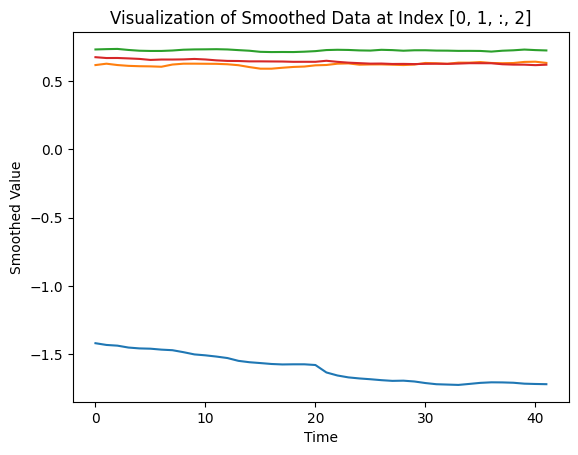

In [8]:
# Visualize the smoothed data
plt.plot(data[5, 2, :, :])
plt.title("Visualization of Smoothed Data at Index [0, 1, :, 2]")
plt.xlabel("Time")
plt.ylabel("Smoothed Value")
plt.show()

In [9]:
train_labels_reshaped = train_labels.reshape(-1,1) #Formatting for input to the CNN model
test_labels_reshaped = test_labels.reshape(-1,1)
final_labels_reshaped = final_labels.reshape(-1,1)

train_labels_reshaped = to_categorical(train_labels_reshaped, 2) #One Hot Encoding
test_labels_reshaped = to_categorical(test_labels_reshaped, 2)
final_labels_reshaped = to_categorical(final_labels_reshaped, 2)

In [10]:
'''
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Reshape, LSTM, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau
import keras
import numpy as np
import time

def build_model(hp):
    model = Sequential([
        Conv2D(filters=64, kernel_size=5, input_shape=(32, 42, 4), padding='same'), 
        Conv2D(filters=64, kernel_size=3, padding='same'),
        Conv2D(filters=64, kernel_size=3, padding='same'),
        MaxPooling2D(pool_size=2, strides=2),
        keras.layers.BatchNormalization(),
        Dropout(0.3),

        Conv2D(filters=128, kernel_size=3, padding='same'), 
        Conv2D(filters=128, kernel_size=3, padding='same'),
        MaxPooling2D(pool_size=2, strides=2),
        keras.layers.BatchNormalization(),
        Dropout(0.35),

        Conv2D(filters=256, kernel_size=3, padding='same'), 

        Reshape((32, -1)), 

        Bidirectional(LSTM(units=64, activation='tanh', return_sequences=True)),
        Dropout(0.25),
        Bidirectional(LSTM(units=128, activation='tanh', return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(units=128, activation='tanh', return_sequences=True)),
        Dropout(0.35),
        Bidirectional(LSTM(units=256, activation='tanh', return_sequences=True)),

        Flatten(),

        Dense(512, activation='relu'), 
        Dropout(0.25), 
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(2, activation='sigmoid')
    ])
    
    # Tune the learning rate
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-7, max_value=1e-2, sampling='log')

    # Compile the model with the tuned learning rate
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                  loss=keras.losses.categorical_crossentropy, 
                  metrics=['accuracy', tf.keras.metrics.RootMeanSquaredError()])
    
    return model

# Instantiate the tuner and perform hyperparameter tuning
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='intro_to_kt')

tuner.search(train_data, train_labels_reshaped, epochs=100, validation_data=(test_data, test_labels_reshaped))

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Optimal learning rate: {best_hps.get('learning_rate')}")


'''

'\nimport kerastuner as kt\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Reshape, LSTM, Bidirectional\nfrom tensorflow.keras.callbacks import ReduceLROnPlateau\nimport keras\nimport numpy as np\nimport time\n\ndef build_model(hp):\n    model = Sequential([\n        Conv2D(filters=64, kernel_size=5, input_shape=(32, 42, 4), padding=\'same\'), \n        Conv2D(filters=64, kernel_size=3, padding=\'same\'),\n        Conv2D(filters=64, kernel_size=3, padding=\'same\'),\n        MaxPooling2D(pool_size=2, strides=2),\n        keras.layers.BatchNormalization(),\n        Dropout(0.3),\n\n        Conv2D(filters=128, kernel_size=3, padding=\'same\'), \n        Conv2D(filters=128, kernel_size=3, padding=\'same\'),\n        MaxPooling2D(pool_size=2, strides=2),\n        keras.layers.BatchNormalization(),\n        Dropout(0.35),\n\n        Conv2D(filters=256, kernel_size=3, padding=\'same\'), \n\n        Reshape((3

In [11]:
# Build the model with the best learning rate
model = Sequential([
    Conv2D(filters=64, kernel_size=5, input_shape=(32, 42, 4), padding='same'), 
    Conv2D(filters=64, kernel_size=3, padding='same'),
    Conv2D(filters=64, kernel_size=3, padding='same'),
    MaxPooling2D(pool_size=2, strides=2),
    BatchNormalization(),
    Dropout(0.3),

    Conv2D(filters=128, kernel_size=3, padding='same'), 
    Conv2D(filters=128, kernel_size=3, padding='same'),
    MaxPooling2D(pool_size=2, strides=2),
    BatchNormalization(),
    Dropout(0.35),

    Conv2D(filters=256, kernel_size=3, padding='same'), 

    Reshape((32, -1)), 

    Bidirectional(LSTM(units=64, activation='tanh', return_sequences=True)),
    Dropout(0.25),
    Bidirectional(LSTM(units=128, activation='tanh', return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(units=128, activation='tanh', return_sequences=True)),
    Dropout(0.35),
    Bidirectional(LSTM(units=256, activation='tanh', return_sequences=True)),

    Flatten(),

    Dense(512, activation='relu'), 
    Dropout(0.25), 
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(2, activation='sigmoid')
])

# Compile the model with the best learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate=4e-5), 
              loss=keras.losses.categorical_crossentropy, 
              metrics=['accuracy', tf.keras.metrics.RootMeanSquaredError()])

# Print model summary
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 42, 64)     │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 21, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 10, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 10, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 10, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 10, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 640)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32, 128)        │       360,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 32, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 32, 512)        │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,32

 Total params: 11,203,714 (42.74 MB)

 Trainable params: 11,203,330 (42.74 MB)

 Non-trainable params: 384 (1.50 KB)

In [12]:
history = model.fit(
    train_data,
    train_labels_reshaped,
    batch_size = 32,
    epochs=100,
    validation_data=(test_data, test_labels_reshaped)
  )

Epoch 1/100


2024-04-22 21:51:52.128829: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.5064 - loss: 0.6928 - root_mean_squared_error: 0.4999 - val_accuracy: 0.5200 - val_loss: 0.7054 - val_root_mean_squared_error: 0.5015
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5442 - loss: 0.6866 - root_mean_squared_error: 0.4981 - val_accuracy: 0.4900 - val_loss: 0.7745 - val_root_mean_squared_error: 0.5079
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5754 - loss: 0.6788 - root_mean_squared_error: 0.4954 - val_accuracy: 0.4900 - val_loss: 0.9230 - val_root_mean_squared_error: 0.5240
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6079 - loss: 0.6576 - root_mean_squared_error: 0.4892 - val_accuracy: 0.4900 - val_loss: 0.9863 - val_root_mean_squared_error: 0.5300
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6354 - loss: 0.6424 - root_mean_squared_error: 0.4842 - val_accuracy: 0.4900 - val_loss: 1.1900 - val_root_mean_squared_error: 0.5508
Epoch 6/100

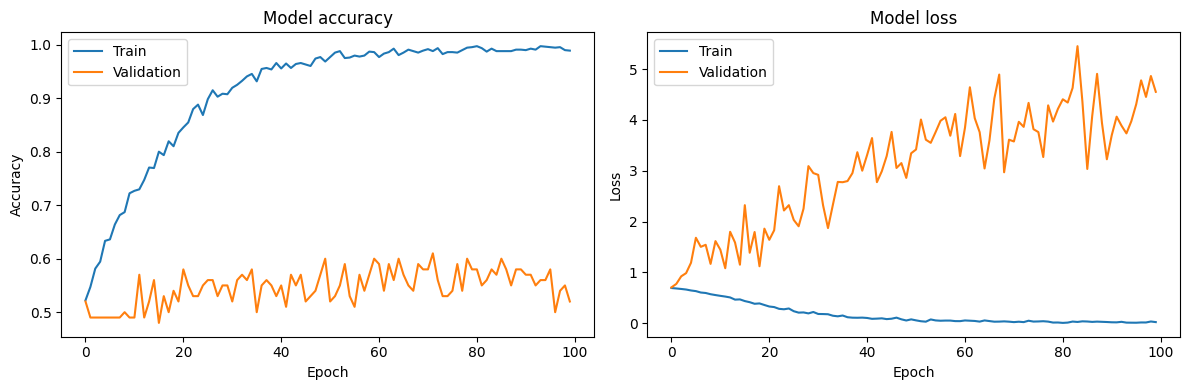

In [13]:
plt.figure(figsize=(12, 4))
dpi = 300

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()

plt.savefig("Loss_Accuracy_curve_try2_1.pdf", dpi=dpi)
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.36      0.42        50
           1       0.51      0.66      0.57        50

    accuracy                           0.51       100
   macro avg       0.51      0.51      0.50       100
weighted avg       0.51      0.51      0.50       100



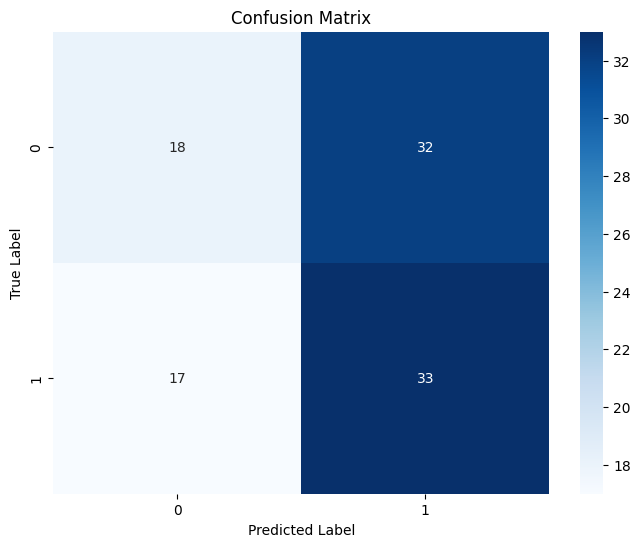

In [14]:
final_test_predictions = model.predict(final_test)

# Convert predictions to class labels
final_test_predictions_labels = np.argmax(final_test_predictions, axis=1)

# Convert true labels to class labels
final_true_labels = np.argmax(final_labels_reshaped, axis=1)

# Display classification report
classification_rep = classification_report(final_true_labels, final_test_predictions_labels)
print("Classification Report:")
print(classification_rep)


# Get unique class labels
class_labels = np.unique(final_true_labels)

# Compute confusion matrix
conf_matrix = confusion_matrix(final_true_labels, final_test_predictions_labels, labels=class_labels)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Classification Report:
              precision    recall  f1-score   support

 Low Arousal       0.51      0.36      0.42        50
High Arousal       0.51      0.66      0.57        50

    accuracy                           0.51       100
   macro avg       0.51      0.51      0.50       100
weighted avg       0.51      0.51      0.50       100



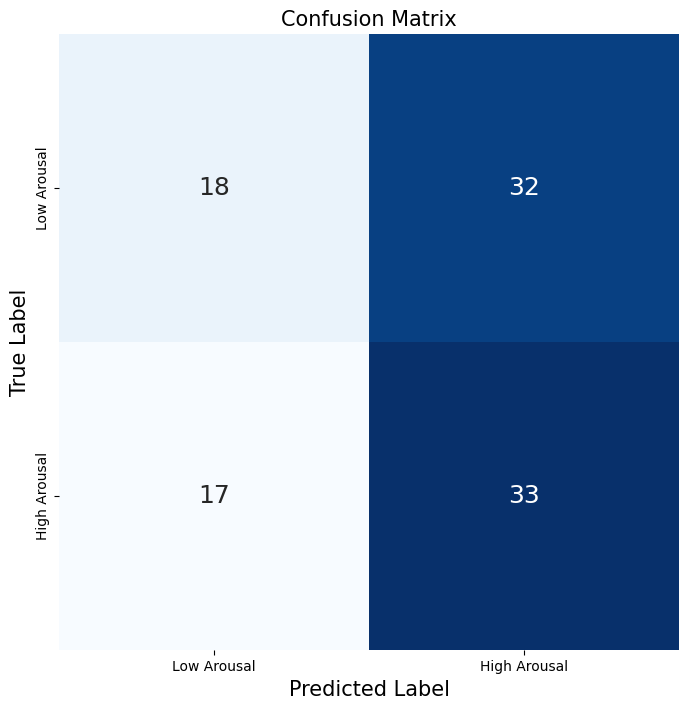

In [15]:
class_label_names = ['Low Arousal', 'High Arousal']

final_test_predictions = model.predict(final_test)

# Convert predictions to class labels
final_test_predictions_labels = np.argmax(final_test_predictions, axis=1)

# Convert true labels to class labels
final_true_labels = np.argmax(final_labels_reshaped, axis=1)

# Display classification report
classification_rep = classification_report(final_true_labels, final_test_predictions_labels, target_names=class_label_names)
print("Classification Report:")
print(classification_rep)

# Get unique class labels
class_labels = np.arange(len(class_label_names))

# Set the fixed value for image_number
image_number = 1.0

# Compute confusion matrix
conf_matrix = confusion_matrix(final_true_labels, final_test_predictions_labels, labels=class_labels)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_label_names, yticklabels=class_label_names, cbar=False, annot_kws={"size": 18})
plt.title("Confusion Matrix", fontsize=15)
plt.xlabel("Predicted Label", fontsize=15)
plt.ylabel("True Label", fontsize=15)
plt.savefig(f"confusion_matrix_{image_number}.jpg", dpi=300)  # Save the plot as JPG
plt.savefig(f"confusion_matrix_{image_number}.pdf")  # Save the plot as PDF
plt.show()